# Topic Modeling

Notebook used to 
- first find meaningful topics on the whole dataset
- second compute average similarities between 'écologie' and the topwords of the found topics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm import tqdm

from IPython.display import display

import dateparser

from ast import literal_eval

#from gensim import models as GensimModels
from gensim.models import TfidfModel, LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec

from sklearn.metrics import pairwise
from scipy import spatial

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
file_sw = open('french_stopwords.txt', 'r')
additional_stopwords = file_sw.readlines()
additional_stopwords = [sw.replace("\n", "") for sw in additional_stopwords]

In [3]:
# load the dataset into a Pandas DataFrame and parse the date
articles = pd.read_csv("../Data/articles_or.csv", parse_dates=['Date'], date_parser=dateparser.parse)
articles.tokens_cor = articles.tokens_cor.apply(literal_eval)

In [4]:
tokens_articles =  articles.tokens_cor.values
tokens_articles = [[t for t in tokens if (t not in additional_stopwords)]
                   for tokens in tokens_articles
                  ]
articles.tokens_cor = tokens_articles

In [5]:
articles.sample()

,Article Title,Journal,Date,Url,Text,tokens,tokens_cor,orientation
407,imnii,La Liberté,1998-11-16,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,imnii ra simple pour réunir économie et éc...,"['imnii', 'simple', 'réunir', 'économie', 'éco...","[mini, simple, réunir, économie, écologie, der...",right


In [6]:
mask_rise = [(date.year < 1990 and date.year > 1970) for date in pd.to_datetime(articles.Date)]
mask_peak = [(date.year > 1990 and date.year < 2000) for date in pd.to_datetime(articles.Date)]
mask_stable = [(date.year > 2000) for date in pd.to_datetime(articles.Date)]

df_rise = articles[mask_rise]
df_peak = articles[mask_peak]
df_stable = articles[mask_stable]

dfs_periods = [df_rise, df_peak, df_stable]

df_rise.shape, df_peak.shape, df_stable.shape

((7209, 8), (7091, 8), (6769, 8))

In [9]:
articles["period"] = ["1970-1990" if date.year < 1990
                      else "1990-2000" if date.year <2000
                      else "2000-2018"
                      for date in pd.to_datetime(articles.Date)
                     ]

## LDA

In [10]:
def assess_lda(list_ntopics
               , tokenized_texts
               , nmin = 5
               , nmax = 0.9
               , random_state = 42
               , passes = 10
               , alpha = 0.01
               , eta = 0.01
               , nb_it = 500
               , eval_every = None
              ):

    dictionary_LDA = corpora.Dictionary(tokenized_texts)
    dictionary_LDA.filter_extremes(no_below=nmin, no_above=nmax)

    corpus = [dictionary_LDA.doc2bow(article) for article in tokenized_texts]
    model_tfidf = TfidfModel(corpus)
    corpus_tfidf = model_tfidf[corpus]
    
    C_vs = np.zeros(len(list_ntopics))
    C_umasss = np.zeros(len(list_ntopics))

    multi_n_topics=list(itertools.chain(*[[n]*n for n in list_ntopics]))
    topic_id=list(itertools.chain(*[list(np.arange(n)) for n in list_ntopics]))
    lda_df = pd.DataFrame(index=[multi_n_topics, topic_id])
    lda_df["top_words"] = ['']*len(lda_df)

    for i, n_topics in tqdm(enumerate(list_ntopics)):
        curr_lda_model = LdaModel(corpus_tfidf
                                         , num_topics=n_topics
                                         , id2word=dictionary_LDA
                                         , passes=passes
                                         , alpha=[alpha]*n_topics
                                         , eta=[eta]*len(dictionary_LDA.keys())
                                         , eval_every=eval_every
                                         , random_state=random_state
                                        )
        
        for j,topic in curr_lda_model.show_topics(formatted=True, num_topics=n_topics, num_words=25):
            lda_df.loc[n_topics,j]["top_words"]=topic

        C_vs[i] = CoherenceModel(model=curr_lda_model
                                 , texts=tokenized_texts
                                 , dictionary=dictionary_LDA
                                 , coherence='c_v'
                                ).get_coherence()

        C_umasss[i] = CoherenceModel(model=curr_lda_model
                                     , corpus=corpus_tfidf
                                     , coherence='u_mass'
                                    ).get_coherence()
        
    return lda_df, C_vs, C_umasss

In [11]:
def plot_cv_cumass(ntopics, cvs, cumasss):
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots(figsize=(10,7))
    # make a plot
    ax.plot(ntopics, cvs, color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("Number of topics",fontsize=14)
    # set y-axis label
    ax.set_ylabel(r"$C_v$",color="red",fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(ntopics, cumasss,color="blue",marker="o")
    ax2.set_ylabel(r"$C_{umass}$",color="blue",fontsize=14)
    plt.show()

In [12]:
N_min = np.round(0.005*len(tokens_articles))
perc_max = 0.5

N_topics = np.arange(3,20,1, dtype=int)

### Per period

In [107]:
C_vs_periods = []
C_umasss_periods = []
lda_dfs = []

for df_curr, period in zip(dfs_periods, ["rise", "peak", "stable"]):
    tokens_articles_curr =  df_curr.tokens_cor.values
    tokens_articles_curr = [[t for t in tokens if (t not in additional_stopwords)]
                            for tokens in tokens_articles_curr
                           ]
    N_min = np.round(0.005*len(tokens_articles_curr))
    
    lda_df, C_vs, C_umasss = assess_lda(list_ntopics = N_topics
                                        , tokenized_texts = tokens_articles_curr
                                        , nmin = N_min
                                        , nmax = perc_max
                                        , random_state = 42
                                        , passes = 10
                                        , alpha = 0.01
                                        , eta = 0.01
                                        , nb_it = 500
                                        , eval_every = None
                                       )
    C_vs_periods.append(C_vs)
    C_umasss_periods.append(C_umasss)
    lda_dfs.append(lda_df)
    
    lda_df.to_csv("lda_3_19_addedstops_0005_05_{}.csv".format(period))

17it [14:22, 50.72s/it]
17it [14:20, 50.60s/it]
17it [12:19, 43.52s/it]


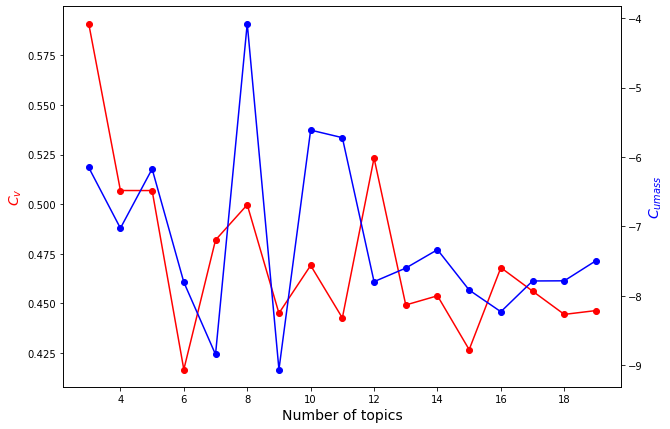

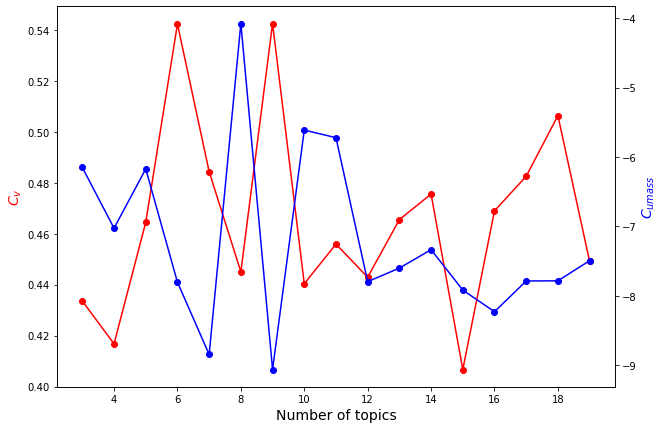

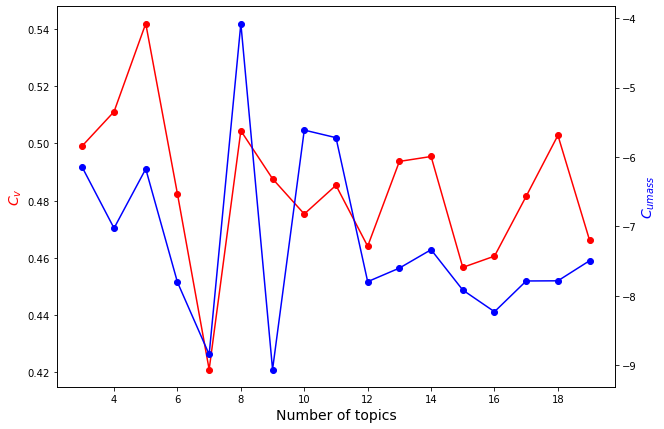

In [109]:
for C_vs, C_umass in zip(C_vs_periods, C_umasss_periods):
    plot_cv_cumass(N_topics, C_vs, C_umasss)

In [111]:
for lda_topics in lda_dfs:
    with pd.option_context('display.max_colwidth', None):
        display(lda_topics.loc[3])

,top_words
0,"0.002*""suisse"" + 0.001*""énergie"" + 0.001*""bien"" + 0.001*""pays"" + 0.001*""environnement"" + 0.001*""valais"" + 0.001*""protection"" + 0.001*""nature"" + 0.001*""ans"" + 0.001*""contre"" + 0.001*""monde"" + 0.001*""entre"" + 0.001*""dont"" + 0.001*""nucléaire"" + 0.001*""projet"" + 0.001*""quil"" + 0.001*""politique"" + 0.001*""fédéral"" + 0.001*""faut"" + 0.001*""millions"" + 0.001*""autres"" + 0.001*""vie"" + 0.001*""ainsi"" + 0.001*""conseil"" + 0.001*""canton"""
1,"0.021*""initiative"" + 0.013*""conseil"" + 0.009*""voix"" + 0.009*""fédéral"" + 0.008*""national"" + 0.007*""cantons"" + 0.007*""article"" + 0.007*""loi"" + 0.007*""peuple"" + 0.007*""etats"" + 0.006*""oui"" + 0.006*""confédération"" + 0.006*""vote"" + 0.006*""énergie"" + 0.006*""transports"" + 0.006*""contre"" + 0.005*""projet"" + 0.005*""commission"" + 0.005*""taxe"" + 0.005*""contreprojet"" + 0.005*""rothenthurm"" + 0.005*""initiatives"" + 0.005*""kaiseraugst"" + 0.004*""majorité"" + 0.004*""motion"""
2,"0.017*""parti"" + 0.013*""sièges"" + 0.011*""élections"" + 0.009*""partis"" + 0.009*""gauche"" + 0.008*""socialiste"" + 0.008*""libéraux"" + 0.008*""socialistes"" + 0.007*""radicaux"" + 0.007*""candidats"" + 0.006*""voix"" + 0.006*""verts"" + 0.006*""majorité"" + 0.006*""siège"" + 0.005*""tour"" + 0.005*""liste"" + 0.005*""pic"" + 0.005*""suffrages"" + 0.005*""électoral"" + 0.005*""libéral"" + 0.005*""radical"" + 0.005*""candidat"" + 0.005*""conseil"" + 0.005*""électeurs"" + 0.004*""parlement"""


,top_words
0,"0.002*""conseil"" + 0.002*""parti"" + 0.002*""suisse"" + 0.001*""projet"" + 0.001*""contre"" + 0.001*""valais"" + 0.001*""national"" + 0.001*""gauche"" + 0.001*""ans"" + 0.001*""fédéral"" + 0.001*""etat"" + 0.001*""millions"" + 0.001*""politique"" + 0.001*""canton"" + 0.001*""hier"" + 0.001*""francs"" + 0.001*""voix"" + 0.001*""bien"" + 0.001*""pays"" + 0.001*""entre"" + 0.001*""environnement"" + 0.001*""non"" + 0.001*""nature"" + 0.001*""initiative"" + 0.001*""président"""
1,"0.024*""agriculture"" + 0.020*""paysans"" + 0.014*""production"" + 0.014*""paiements"" + 0.013*""agricole"" + 0.012*""directs"" + 0.012*""initiative"" + 0.011*""taxe"" + 0.011*""alfa"" + 0.009*""transit"" + 0.008*""gant"" + 0.008*""article"" + 0.008*""exploitations"" + 0.007*""produits"" + 0.007*""énergie"" + 0.007*""marché"" + 0.007*""lourds"" + 0.006*""agriculteurs"" + 0.006*""agricoles"" + 0.006*""biologique"" + 0.006*""coller"" + 0.006*""consommateurs"" + 0.006*""rail"" + 0.006*""producteurs"" + 0.006*""lait"""
2,"0.012*""chaleur"" + 0.012*""garage"" + 0.011*""déchets"" + 0.011*""navettes"" + 0.010*""chauffage"" + 0.008*""iris"" + 0.008*""emballage"" + 0.007*""wh"" + 0.007*""papier"" + 0.007*""emballages"" + 0.007*""solaire"" + 0.007*""micros"" + 0.007*""grimpent"" + 0.006*""prix"" + 0.006*""recyclage"" + 0.006*""énergie"" + 0.006*""lavage"" + 0.006*""élimination"" + 0.006*""pompe"" + 0.006*""pompes"" + 0.006*""sachet"" + 0.005*""litres"" + 0.005*""appareils"" + 0.005*""électricité"" + 0.005*""écologique"""


,top_words
0,"0.002*""parti"" + 0.002*""conseil"" + 0.002*""verts"" + 0.002*""suisse"" + 0.002*""gauche"" + 0.002*""initiative"" + 0.002*""projet"" + 0.001*""contre"" + 0.001*""politique"" + 0.001*""valais"" + 0.001*""président"" + 0.001*""ans"" + 0.001*""etat"" + 0.001*""fédéral"" + 0.001*""nature"" + 0.001*""hier"" + 0.001*""écologistes"" + 0.001*""pays"" + 0.001*""canton"" + 0.001*""recours"" + 0.001*""entre"" + 0.001*""droit"" + 0.001*""bien"" + 0.001*""énergie"" + 0.001*""national"""
1,"0.036*""appareil"" + 0.026*""appareils"" + 0.025*""réparation"" + 0.023*""rapidement"" + 0.021*""entreront"" + 0.021*""usagés"" + 0.020*""prix"" + 0.019*""meilleur"" + 0.014*""verset"" + 0.014*""media"" + 0.014*""reculons"" + 0.013*""financement"" + 0.013*""gratuitement"" + 0.012*""offrons"" + 0.012*""egalement"" + 0.012*""mark"" + 0.012*""concernée"" + 0.011*""raisonnables"" + 0.011*""avantageux"" + 0.011*""naturellement"" + 0.011*""shopping"" + 0.011*""marchandise"" + 0.011*""atelier"" + 0.011*""acheté"" + 0.010*""emballage"""
2,"0.028*""tél"" + 0.024*""zisyadis"" + 0.019*""ford"" + 0.018*""garage"" + 0.018*""pièces"" + 0.015*""pompiste"" + 0.015*""annecatherine"" + 0.015*""wow"" + 0.015*""chinois"" + 0.014*""ruth"" + 0.012*""prime"" + 0.011*""fax"" + 0.011*""zurkinden"" + 0.010*""profitez"" + 0.010*""papistes"" + 0.010*""charges"" + 0.009*""lex"" + 0.009*""radicale"" + 0.008*""lavage"" + 0.008*""leasing"" + 0.008*""balcon"" + 0.008*""appartement"" + 0.008*""chauffage"" + 0.007*""amen"" + 0.007*""fauteuil"""


## Per political color

In [13]:
df_neutral = articles[articles.orientation=="neutral"]
df_right = articles[articles.orientation=="right"]
df_left = articles[articles.orientation=="left"]

dfs_color = [df_neutral, df_right, df_left]

df_neutral.shape, df_right.shape, df_left.shape

((2557, 9), (16433, 9), (3587, 9))

In [27]:
C_vs_color = []
C_umasss_color = []
lda_dfs = []

for df_curr, period in zip(dfs_color, ["neutral", "right", "left"]):
    tokens_articles_curr =  df_curr.tokens_cor.values
    tokens_articles_curr = [[t for t in tokens if (t not in additional_stopwords)]
                            for tokens in tokens_articles_curr
                           ]
    N_min = np.round(0.005*len(tokens_articles_curr))
    
    lda_df, C_vs, C_umasss = assess_lda(list_ntopics = N_topics
                                        , tokenized_texts = tokens_articles_curr
                                        , nmin = N_min
                                        , nmax = perc_max
                                        , random_state = 42
                                        , passes = 10
                                        , alpha = 0.01
                                        , eta = 0.01
                                        , nb_it = 500
                                        , eval_every = None
                                       )
    C_vs_color.append(C_vs)
    C_umasss_color.append(C_umasss)
    lda_dfs.append(lda_df)
    
    lda_df.to_csv("lda_3_19_addedstops_0005_05_{}.csv".format(period))

17it [05:31, 19.53s/it]
17it [1:28:33, 312.55s/it]
17it [2:29:55, 529.13s/it]


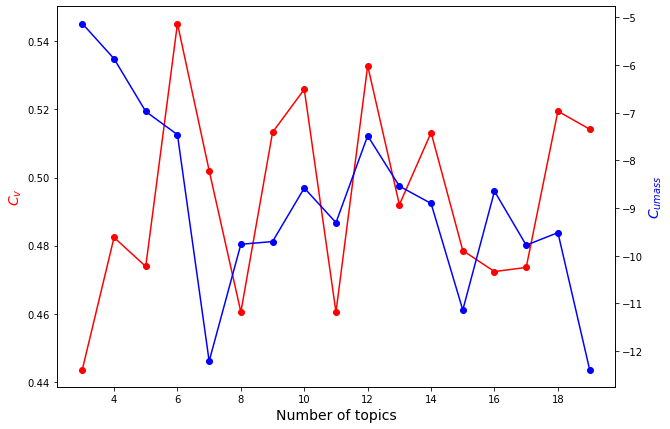

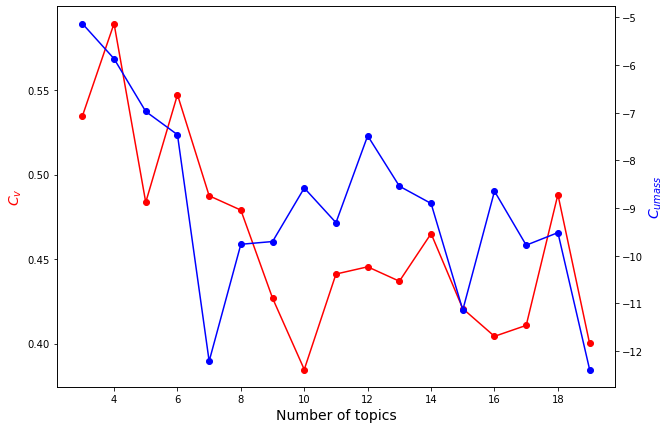

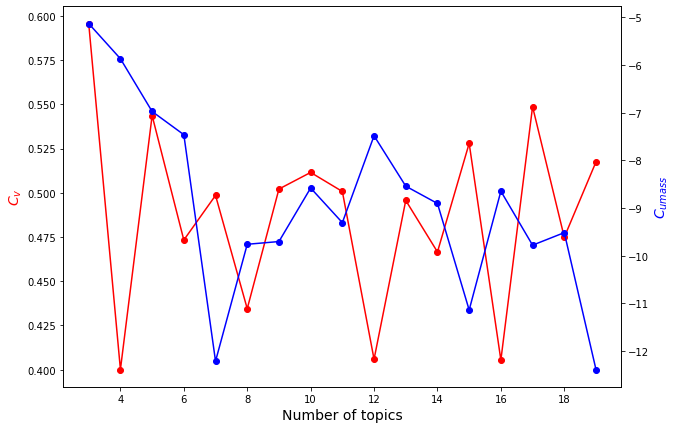

In [29]:
for C_vs, C_umass in zip(C_vs_color, C_umasss_color):
    plot_cv_cumass(N_topics, C_vs, C_umasss)

### Global

In [11]:
lda_df, C_vs, C_umasss = assess_lda(list_ntopics = N_topics
                                    , tokenized_texts = tokens_articles
                                    , nmin = N_min
                                    , nmax = perc_max
                                    , random_state = 42
                                    , passes = 10
                                    , alpha = 0.01
                                    , eta = 0.01
                                    , nb_it = 500
                                    , eval_every = None
                                   )

17it [44:02, 155.45s/it]


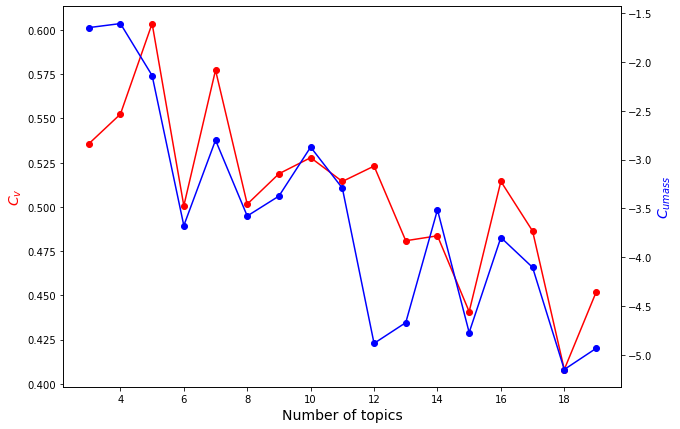

In [12]:
plot_cv_cumass(N_topics, C_vs, C_umasss)

In [45]:
# w/ tf-idf representation
#lda_df.to_csv("lda_3_19_addedstops_113_05.csv")
# w/out tf-idf representation: BoW
#lda_df.to_csv("lda_bow_3_19_addedstops_113_05.csv")

In [14]:
topics_df = pd.read_csv("lda_3_19_addedstops_113_05.csv")

In [15]:
topics_df = topics_df.set_index(["Unnamed: 0", "Unnamed: 1"])

In [176]:
curr_N = 11

In [ ]:
# 18 | 12 | 7 | 3 | 10 | 8 | 9 | 11

In [205]:
#topics_df["topic"] = ['']*len(topics_df)
#topics_df.loc[curr_N,9]["topic"]="?"
#topics_df.loc[curr_N,1]["topic"]="production / consommation"
#topics_df.loc[curr_N,2]["topic"]="patrie?"

In [36]:
with pd.option_context('display.max_colwidth', None):
    display(topics_df.loc[12])

,top_words,topic
Unnamed: 1,,
0,"0.100*""télésiège"" + 0.065*""entente"" + 0.057*""stick"" + 0.053*""gamin"" + 0.048*""vigilance"" + 0.039*""démocrates"" + 0.039*""votes"" + 0.036*""votants"" + 0.028*""radicales"" + 0.027*""hôpitaux"" + 0.027*""justesse"" + 0.024*""allocations"" + 0.023*""rejetée"" + 0.020*""barbara"" + 0.019*""otto"" + 0.018*""werner"" + 0.015*""deviné"" + 0.014*""conquis"" + 0.013*""voter"" + 0.013*""contestation"" + 0.012*""protestations"" + 0.011*""renoncé"" + 0.010*""rapprochement"" + 0.010*""revendication"" + 0.010*""voulaient""",¿accident?
1,"0.011*""loup"" + 0.010*""chasseurs"" + 0.008*""chasse"" + 0.006*""berlin"" + 0.006*""merde"" + 0.006*""film"" + 0.006*""lynx"" + 0.006*""loups"" + 0.006*""démocrates"" + 0.005*""grève"" + 0.005*""ministres"" + 0.005*""moutons"" + 0.005*""arnold"" + 0.004*""rente"" + 0.004*""pacifistes"" + 0.004*""aviation"" + 0.004*""lue"" + 0.004*""mine"" + 0.003*""chaud"" + 0.003*""vagues"" + 0.003*""autorisations"" + 0.003*""fortune"" + 0.003*""démocrate"" + 0.003*""voter"" + 0.003*""millier""",loup
2,"0.052*""montblanc"" + 0.043*""chamois"" + 0.036*""municipales"" + 0.029*""tél"" + 0.027*""garage"" + 0.025*""km"" + 0.024*""passagers"" + 0.023*""cyclistes"" + 0.021*""pièces"" + 0.019*""suspension"" + 0.018*""ferroviaires"" + 0.018*""autoroutier"" + 0.016*""aérien"" + 0.015*""routières"" + 0.015*""redevances"" + 0.013*""wow"" + 0.013*""prix"" + 0.013*""réparation"" + 0.012*""liaisons"" + 0.012*""piétons"" + 0.011*""automatique"" + 0.010*""villa"" + 0.010*""appareil"" + 0.009*""marly"" + 0.009*""louer""",transport?
3,"0.115*""fac"" + 0.095*""maggi"" + 0.060*""perdent"" + 0.054*""collecte"" + 0.042*""lessive"" + 0.000*""pluie"" + 0.000*""peinture"" + 0.000*""nés"" + 0.000*""londres"" + 0.000*""langage"" + 0.000*""hein"" + 0.000*""granges"" + 0.000*""déroulera"" + 0.000*""prévues"" + 0.000*""teneur"" + 0.000*""von"" + 0.000*""sétait"" + 0.000*""recul"" + 0.000*""radicale"" + 0.000*""prévoyait"" + 0.000*""prévisions"" + 0.000*""poche"" + 0.000*""partisans"" + 0.000*""classique"" + 0.000*""quelquesuns""",?
4,"0.039*""micros"" + 0.039*""déchets"" + 0.024*""bouteilles"" + 0.021*""papier"" + 0.020*""produits"" + 0.020*""emballages"" + 0.019*""emballage"" + 0.018*""recyclage"" + 0.016*""verre"" + 0.016*""championnats"" + 0.013*""tonnes"" + 0.012*""plastique"" + 0.011*""aluminium"" + 0.011*""ordures"" + 0.011*""élimination"" + 0.011*""coop"" + 0.010*""usine"" + 0.010*""lait"" + 0.009*""pet"" + 0.009*""écologiquement"" + 0.009*""produit"" + 0.009*""poisson"" + 0.009*""décharge"" + 0.009*""récupération"" + 0.009*""sacs""",déchets
5,"0.034*""nostri"" + 0.034*""bruxelles"" + 0.030*""sortants"" + 0.025*""koi"" + 0.023*""pompiste"" + 0.023*""bodenmann"" + 0.022*""papistes"" + 0.020*""conservateurs"" + 0.020*""washington"" + 0.019*""villeneuve"" + 0.018*""fermait"" + 0.018*""fa"" + 0.018*""belge"" + 0.016*""couteau"" + 0.015*""weiss"" + 0.015*""strasbourg"" + 0.014*""blessé"" + 0.014*""pénale"" + 0.013*""électeur"" + 0.013*""allié"" + 0.013*""électoraux"" + 0.012*""démocrate"" + 0.012*""lice"" + 0.012*""plainte"" + 0.012*""agonie""",?
6,"0.067*""marée"" + 0.066*""brûlez"" + 0.065*""pétrole"" + 0.064*""golfe"" + 0.054*""noire"" + 0.054*""pétrolier"" + 0.052*""côtes"" + 0.044*""défrichement"" + 0.035*""euro"" + 0.034*""euros"" + 0.031*""prestige"" + 0.023*""tonnes"" + 0.021*""catastrophe"" + 0.021*""brut"" + 0.021*""interprétation"" + 0.019*""ticket"" + 0.015*""atlantique"" + 0.013*""plateforme"" + 0.011*""nettoyage"" + 0.010*""paiement"" + 0.008*""litres"" + 0.007*""pétrolière"" + 0.007*""opérations"" + 0.006*""fragile"" + 0.005*""bateau""",pétrole
7,"0.022*""parti"" + 0.015*""gauche"" + 0.013*""sièges"" + 0.012*""élections"" + 0.012*""socialistes"" + 0.011*""socialiste"" + 0.011*""partis"" + 0.010*""radicaux"" + 0.010*""verts"" + 0.009*""voix"" + 0.009*""candidats"" + 0.009*""libéraux"" + 0.009*""pic"" + 0.008*""majorité"" + 0.007*""liste"" + 0.007*""siège"" + 0.007*""conseil"" + 0.007*""radical"

In [207]:
#topics_df.to_csv("lda_3_19_addedstops_113_05.csv")

In [35]:
SELECTED_TOPICS_N = 11
SELECTED_TOPICS_INDICES = [1, 2, 4, 6, 7, 8, 9, 10, 11]
SELECTED_TOPICS_NAMES = ['loup'
                         , 'transport'
                         , 'déchets'
                         , 'pétrole'
                         , 'partis politiques'
                         , 'initiatives populaires'
                         , 'énergie'
                         , 'aménagement / stations'
                         , 'agriculture'
                        ]

## Articles distribution over the selected topics

In [16]:
%%time

tokenized_texts = tokens_articles

dictionary_LDA = corpora.Dictionary(tokenized_texts)
dictionary_LDA.filter_extremes(no_below=113, no_above=0.5)

corpus = [dictionary_LDA.doc2bow(article) for article in tokenized_texts]
model_tfidf = TfidfModel(corpus)
corpus_tfidf = model_tfidf[corpus]

lda_12 = LdaModel(corpus_tfidf
                  , num_topics=12
                  , id2word=dictionary_LDA
                  , passes=10
                  , alpha=[0.01]*12
                  , eta=[0.01]*len(dictionary_LDA.keys())
                  , eval_every=None
                  , random_state=42
                 )

CPU times: user 2min 9s, sys: 490 ms, total: 2min 10s
Wall time: 2min 10s


In [17]:
articles["topics_distrib"] = [lda_12.get_document_topics(corpus_tfidf[i], minimum_probability=0.0)
                              for i in range(len(articles))]

In [18]:
articles.sample(3)

,Article Title,Journal,Date,Url,Text,tokens,tokens_cor,orientation,period,topics_distrib
3659,"26 MONDE «ERIKA» Le naufrage du pétrolier, en ...",Le Nouvelliste,2012-05-25,https://www.e-newspaperarchives.ch/?a=d&d=NVE2...,"26 MONDE « ERIKA » Le naufrage du pétrolier ,...","['monde', 'erika', 'naufrage', 'pétrolier', 'd...","[monde, erika, naufrage, pétrolier, décembre, ...",right,2000-2018,"[(0, 0.0010232456), (1, 0.0010232456), (2, 0.0..."
17783,Les trouillards Il fut un temps où l'on ...,Le Confédéré,2002-11-01,https://www.e-newspaperarchives.ch/?a=d&d=LCE2...,Les trouillards Il fut un temps où lon prenai...,"['trouillards', 'temps', 'lon', 'prenait', 'te...","[trouillards, temps, lon, prenait, temps, étud...",left,2000-2018,"[(0, 0.001033869), (1, 0.001033869), (2, 0.001..."
5733,Abonnements écologiques Peu d'écho en Su...,La Liberté,1985-04-01,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,Abonnements écologiques Peu décho en Suisse r...,"['abonnements', 'écologiques', 'peu', 'décho',...","[abonnements, écologiques, déco, suisse, roman...",right,1970-1990,"[(0, 0.0010332874), (1, 0.034446515), (2, 0.00..."


In [19]:
articles["topic_max"] = [np.array(topic_distrib).flatten()[1::2].argmax()
                        for topic_distrib in articles.topics_distrib]

print(len(articles[articles.topic_max==8])/len(articles))

0.9821942685033441


In [20]:
for i in range(12):
    articles["topic_"+str(i)]= [np.array(topic_distrib).flatten()[1::2][i]
                                for topic_distrib in articles.topics_distrib]
    print(np.mean(articles["topic_"+str(i)]))

0.0024055766628389413
0.022958202584203172
0.007752445255756865
0.0014806072472550809
0.011778691896875347
0.004506346892337
0.0025562903037665776
0.050597733769181835
0.8245692784502819
0.012380641264503249
0.049412589742389705
0.009601596382738654


In [21]:
articles.groupby("orientation").mean()

,topic_max,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
orientation,,,,,,,,,,,,,
left,7.990521,0.002339,0.020475,0.002912,0.001307,0.007484,0.003434,0.001676,0.051255,0.834019,0.012038,0.043875,0.019187
neutral,7.985139,0.002057,0.024900,0.005146,0.002048,0.034390,0.002978,0.002019,0.016414,0.829162,0.011589,0.058981,0.010317
right,7.950040,0.002474,0.023198,0.009215,0.001430,0.009198,0.004978,0.002832,0.055773,0.821792,0.012579,0.049132,0.007398


In [22]:
articles.groupby("period").mean()

,topic_max,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
period,,,,,,,,,,,,,
1970-1990,7.979058,0.002510,0.021858,0.003424,0.001438,0.010740,0.004276,0.001870,0.057125,0.833222,0.010351,0.047191,0.005994
1990-2000,7.973266,0.002367,0.023089,0.006865,0.001386,0.013691,0.004625,0.002359,0.051464,0.819602,0.010588,0.049591,0.014373
2000-2018,7.928407,0.002344,0.023899,0.012957,0.001624,0.010747,0.004605,0.003442,0.043256,0.821401,0.016298,0.051403,0.008024


In [172]:
def bootstrap_CI(data, nbr_draws=1000, ci=95):
    """
    Role : compute the given confidence interval (CI) around the mean of an array of values

    # PARAMETERS
    data : array containing the values on which we want to compute the mean (and thus CI)
    nbr_draws : integer defining the number of random selections when bootstraping data
    ci : float (default 95) defines the amount of precision wanted in percentage

    # RETURN
    list containing the CI around the mean : [2.5 percentile, 97.5 percentile]
    """
    # compute the percentiles according to the given confidence interval
    low_perc = (100 - ci) / 2
    high_perc = 100 - low_perc

    # defining arrays that will be filled during the random bootstraps
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(
            0, len(data), len(data)
        )  # random selection of data in the data array (with replacement)
        data_tmp = data[
            indices
        ]  # creation of a new array of values from the data values
        means[n] = np.nanmean(data_tmp)  # calculate the mean of the new array of values

    return [np.nanpercentile(means, low_perc), np.nanpercentile(means, high_perc)]

In [160]:
COLOR_70 = "#684551"
COLOR_90 = "#402E2A"
COLOR_2K = "#6E7F5D"
COLORS_PERIODS = [COLOR_70, COLOR_90, COLOR_2K]

COLOR_L = "#EC9A9A"
COLOR_N = "#EDF8ED"
COLOR_R = "#457B9D"
COLORS_ORIENTATIONS = [COLOR_L, COLOR_N, COLOR_R]

In [309]:
width = 0.25
bins_centers = list(range(len(SELECTED_TOPICS_INDICES)))
print(len(bins_centers))
bins_centers = bins_centers + [pos+width for pos in bins_centers] + [pos-width for pos in bins_centers]
bins_centers.sort()

9


In [275]:
means_topic_or = articles.groupby("orientation")[["topic_"+str(i) for i in SELECTED_TOPICS_INDICES]].mean()
stds_topic_or = articles.groupby("orientation")[["topic_"+str(i) for i in SELECTED_TOPICS_INDICES]].std()
btstrp_topic_or = articles.groupby("orientation")[["topic_"+str(i) for i in SELECTED_TOPICS_INDICES]].agg(lambda x: bootstrap_CI(x.values))

In [276]:
means_topic_periods = articles.groupby("period")[["topic_"+str(i) for i in SELECTED_TOPICS_INDICES]].mean()
stds_topic_periods = articles.groupby("period")[["topic_"+str(i) for i in SELECTED_TOPICS_INDICES]].std()
btstrp_topic_periods = articles.groupby("period")[["topic_"+str(i) for i in SELECTED_TOPICS_INDICES]].agg(lambda x: bootstrap_CI(x.values))

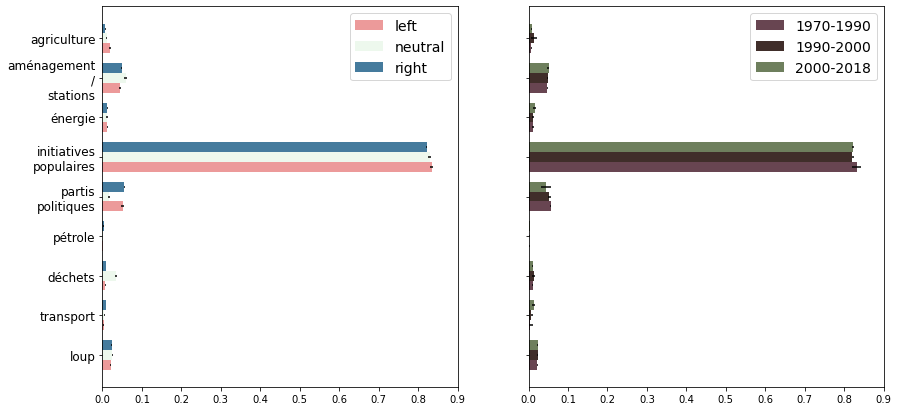

In [310]:
fig, ax = plt.subplots(figsize=(14,7)
                       , nrows=1
                       , ncols=2
                       , sharey=True
                       , sharex=True
                      )

# according to political orientations
for i, orientation in enumerate(["left", "neutral", "right"]):
    ys = means_topic_or.loc[orientation]
    #yerrs = stds_topic_or.loc[orientation]
    yerrs = btstrp_topic_or.loc[orientation]
    yerrs = [np.abs(np.array(yerr)-y) for yerr,y in zip(ys, yerrs)]
    yerrs = [[yerr[0] for yerr in yerrs], [yerr[1] for yerr in yerrs]]
    ax[0].barh(bins_centers[i::3]
            , ys
            , height=width
            , color=COLORS_ORIENTATIONS[i]
            , xerr=yerrs
            , label=orientation
           )
    ax[0].legend(fontsize=14)
    
# according to periods
for i, period in enumerate(["1970-1990", "1990-2000", "2000-2018"]):
    ys = means_topic_periods.loc[period]
    #yerrs = stds_topic_periods.loc[period]
    yerrs = btstrp_topic_or.loc[orientation]
    yerrs = [np.abs(np.array(yerr)-y) for yerr,y in zip(ys, yerrs)]
    yerrs = [[yerr[0] for yerr in yerrs], [yerr[1] for yerr in yerrs]]
    ax[1].barh(bins_centers[i::3]
            , ys
            , height=width
            , color=COLORS_PERIODS[i]
            , xerr=yerrs
            , label=period
           )
    ax[1].legend(fontsize=14)
    
    
ax[0].set_yticks(ticks=bins_centers[1::3])
ax[0].set_yticklabels(labels=[name if (' ' not in name) else name.replace(' ', '\n')
                              for name in SELECTED_TOPICS_NAMES
                             ]
                      , fontsize=12
                     )
plt.xlim(0.,.9)
plt.show()

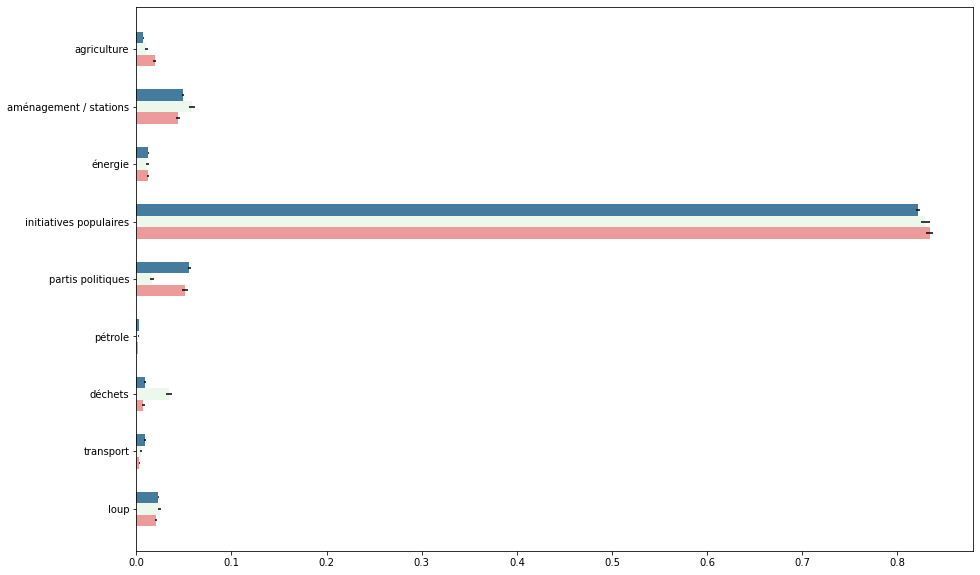

In [235]:
plt.figure(figsize=(15,10))

for i, orientation in enumerate(["left", "neutral", "right"]):
    ys = means_topic_or.loc[orientation]
    #yerrs = stds_topic_or.loc[orientation]
    yerrs = btstrp_topic_or.loc[orientation]
    yerrs = [np.abs(np.array(yerr)-y) for yerr,y in zip(ys, yerrs)]
    yerrs = [[yerr[0] for yerr in yerrs], [yerr[1] for yerr in yerrs]]
    plt.barh(bins_centers[i::3]
            , ys
            , height=width
            , color=COLORS_ORIENTATIONS[i]
            , xerr=yerrs
           )
    plt.yticks(ticks=bins_centers[1::3], labels=SELECTED_TOPICS_NAMES)
    #plt.set_xticklabels(SELECTED_TOPICS_NAMES)
    
    
#plt.bar(bins_centers[1::3], np.ones(len(bins_centers[1::3])), width=width, color='b')
#plt.bar(bins_centers[2::3], np.ones(len(bins_centers[1::3])), width=width, color='g')


In [164]:
means_topic_periods = articles.groupby("period")[["topic_"+str(i) for i in range(12)]].mean()
stds_topic_periods = articles.groupby("period")[["topic_"+str(i) for i in range(12)]].std()

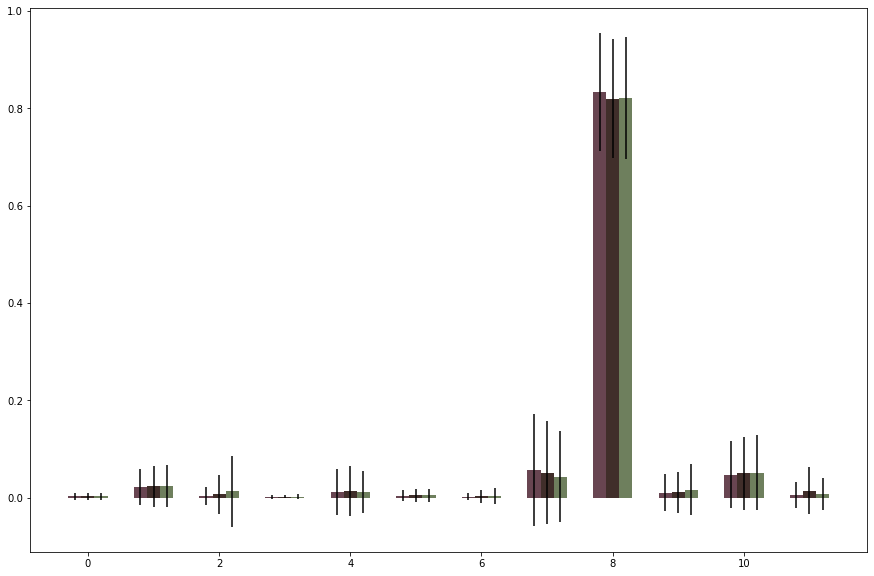

In [156]:
plt.figure(figsize=(15,10))

for i, period in enumerate(["1970-1990", "1990-2000", "2000-2018"]):
    ys = means_topic_periods.loc[period]
    yerrs = stds_topic_periods.loc[period]
    plt.bar(bins_centers[i::3]
            , ys
            , width=width
            , color=COLORS_PERIODS[i]
            , yerr=yerrs
           )

In [165]:
TOPICS_NB = 12
N_TOPWORDS = 25
topics_topwords = topics_df.loc[TOPICS_NB].top_words.values
topics_topwords = [[w.split('"')[1] for w in topic.split("+")[:N_TOPWORDS]]
                   for topic in topics_topwords
                  ]
topics_name = topics_df.loc[TOPICS_NB].topic.values

topics_words_weights = [[float(w.split('*')[0]) for w in topic.split("+")[:N_TOPWORDS]]
                        for topic in topics_df.loc[TOPICS_NB].top_words.values
                       ]

In [166]:
#[np.array([w_ecolo in topic for topic in topics_topwords]).any() for w_ecolo in ecologie_lemma]

## Average cosine-sim to topwords for each period

In [167]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [168]:
# load models
model_rise = Word2Vec.load('model_rise_cor_300')
model_stable = Word2Vec.load('model_stable_cor_300')
model_peak = Word2Vec.load('model_peak_cor_300')

In [169]:
ecologie_lemma = ["écologie", "écologiquement", "écologiste", "écologistes"]

In [170]:
periods = ["1970-1990", "1990-2000", "2000-2018"]
models = [model_rise, model_peak, model_stable]
colors = ["red", "blue", "green"]

angles=np.linspace(0, 2*np.pi, len(topics_topwords), endpoint=False)
print(len(angles))
angles=np.concatenate((angles,[angles[0]]))

12


In [178]:
ecologie_lemma_vectors = [model_rise.wv[w_ecolo] for w_ecolo in ecologie_lemma]
topics_vec = [[model_rise.wv[w_topic] for w_topic in topic if (w_topic in model_rise.wv.key_to_index.keys())] 
              for topic in topics_topwords]

0 [25, 25, 25, 25, 24, 25, 25, 24, 25, 25, 25, 25, 25, 25, 24, 24, 25, 25, 24]
1 [24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
2 [24, 24, 25, 25, 24, 25, 25, 24, 25, 25, 25, 25, 24, 25, 25, 25, 24, 25, 25]


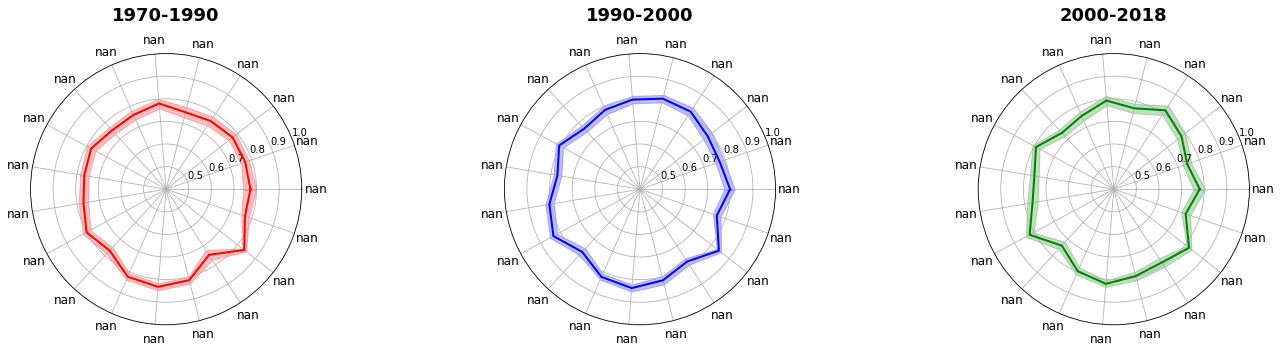

In [194]:
fig = plt.figure(figsize=(20,5))

for i, model in enumerate(models):
    
    ecologie_lemma_vectors = [model.wv[w_ecolo] for w_ecolo in ecologie_lemma]
    topics_vec = [[model.wv[w_topic] for w_topic in topic if (w_topic in model.wv.key_to_index.keys())] 
                  for topic in topics_topwords]
    
    curr_weights = [[weight for weight, w_topic in zip(weights, topic) 
                     if (w_topic in model.wv.key_to_index.keys())] 
                    for weights, topic in zip(topics_words_weights, topics_topwords)]
    
    print(i, [len(topic) for topic in topics_vec])
    
    
    # not weighted
    
    stats_mean = [np.mean(1-pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()) 
                  for word_vects in topics_vec] 
    stats_mean = np.concatenate((stats_mean,[stats_mean[0]]))
    
    #stats_std = [np.std(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()) 
     #             for word_vects in topics_vec] 
    #stats_std = np.concatenate((stats_std,[stats_std[0]]))
    
    stats_btstrp = [bootstrap_CI(1-pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten())
                    for word_vects in topics_vec
                   ]
    stats_btstrp = np.concatenate((stats_btstrp,[stats_btstrp[0]]))
    stats_btstrp_min = [btstrp[0] for btstrp in stats_btstrp]
    stats_btstrp_max = [btstrp[1] for btstrp in stats_btstrp]
    
    """
    
    # weighted by importance in topic
    stats = [weighted_avg_and_std(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()
                                  , words_weights
                                 )
             for word_vects, words_weights in zip(topics_vec, curr_weights)
            ]
    stats_mean = [av_std[0] for av_std in stats]
    stats_std = [av_std[1] for av_std in stats]
    stats_mean = np.concatenate((stats_mean,[stats_mean[0]]))
    stats_std = np.concatenate((stats_std,[stats_std[0]]))
    """
    
    # radial plot
    ax = fig.add_subplot(int(str("1"+"3"+"{}".format(i+1))), polar=True)
        
    ax.plot(angles
            , stats_mean
            #, 'o-'
            , color=colors[i]
            , linewidth=2
           )
    ax.fill_between(angles
            , y1=stats_btstrp_min#stats_mean-stats_std
            , y2= stats_btstrp_max#stats_mean+stats_std
            , alpha=0.25
            , color=colors[i]
           )

    ax.set_thetagrids(angles[:-1]* 180/np.pi, topics_name, fontsize=12)
    ax.set_rlim(0.4,1.)
    ax.set_title(periods[i]
                 , fontsize = 18, weight = 'demibold',  x = 0.5, y = 1.1
                )
    ax.grid(True)
    
plt.tight_layout()
#plt.savefig("test_spider.png")

0 [25, 25, 25, 25, 25, 25, 24, 25, 25, 25, 25, 24]
1 [25, 25, 25, 25, 25, 24, 25, 25, 25, 25, 25, 25]
2 [24, 25, 25, 24, 25, 23, 25, 25, 25, 25, 25, 24]


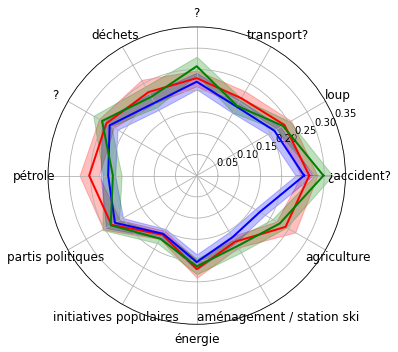

In [175]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(int(str("1"+"3"+"{}".format(i+1))), polar=True)

for i, model in enumerate(models):
    
    ecologie_lemma_vectors = [model.wv[w_ecolo] for w_ecolo in ecologie_lemma]
    topics_vec = [[model.wv[w_topic] for w_topic in topic if (w_topic in model.wv.key_to_index.keys())] 
                  for topic in topics_topwords]
    print(i, [len(topic) for topic in topics_vec])
    
    stats_mean = [np.mean(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()) 
                  for word_vects in topics_vec] 
    stats_mean = np.concatenate((stats_mean,[stats_mean[0]]))
    
    #stats_std = [np.std(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()) 
     #             for word_vects in topics_vec] 
    #stats_std = np.concatenate((stats_std,[stats_std[0]]))
    
    stats_btstrp = [bootstrap_CI(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten())
                    for word_vects in topics_vec
                   ]
    stats_btstrp = np.concatenate((stats_btstrp,[stats_btstrp[0]]))
    stats_btstrp_min = [btstrp[0] for btstrp in stats_btstrp]
    stats_btstrp_max = [btstrp[1] for btstrp in stats_btstrp]
    
    #ax = fig.add_subplot(int(str("1"+"3"+"{}".format(i+1))), polar=True)
        
    ax.plot(angles
            , stats_mean
            #, 'o-'
            , color=colors[i]
            , linewidth=2
           )
    ax.fill_between(angles
            , y1=stats_btstrp_min
            , y2= stats_btstrp_max
            , alpha=0.25
            , color=colors[i]
           )

    ax.set_thetagrids(angles[:-1]* 180/np.pi, topics_name, fontsize=12)
    ax.set_rlim(0,0.35)
    #ax.set_title(periods[i]
    #             , fontsize = 18, weight = 'demibold',  x = 0.5, y = 1.1
    #            )
    plt.grid(True)
    
plt.tight_layout()
#plt.savefig("test_spider.png")

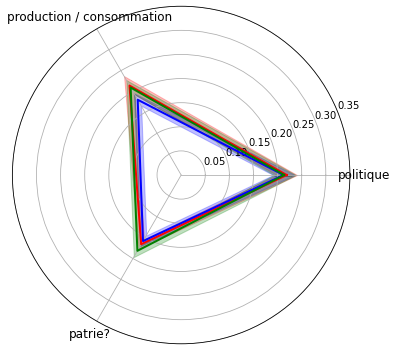

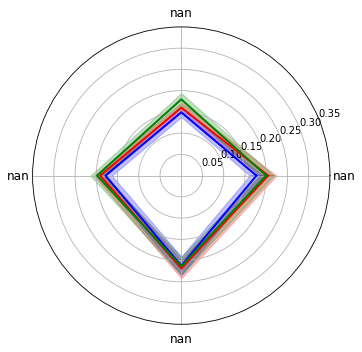

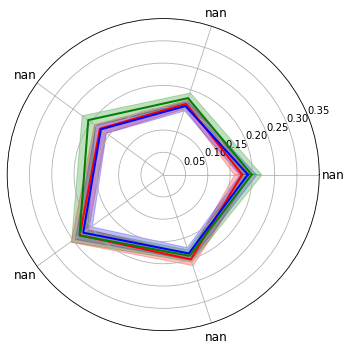

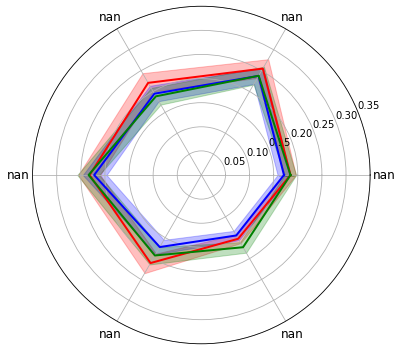

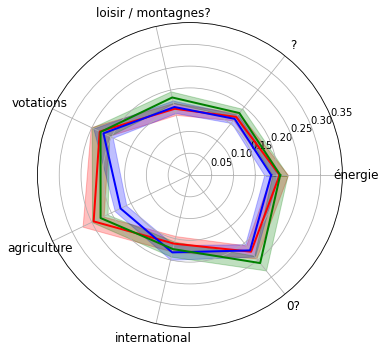

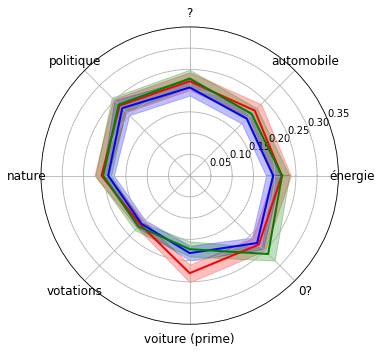

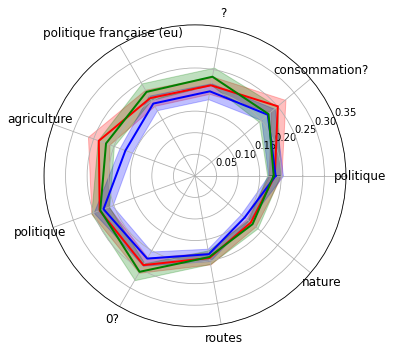

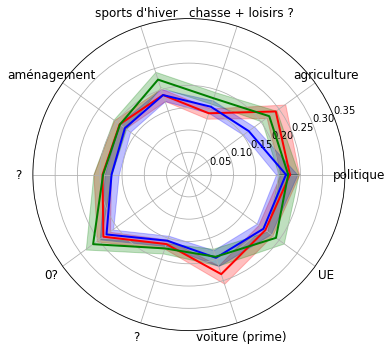

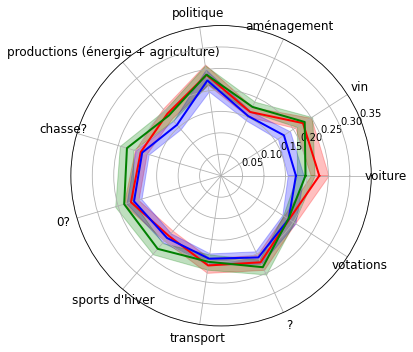

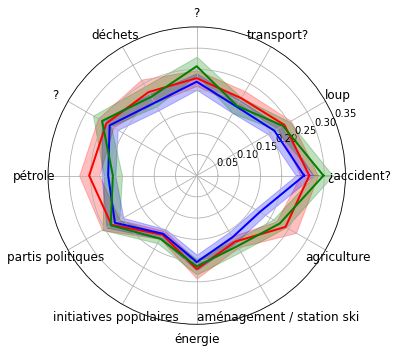

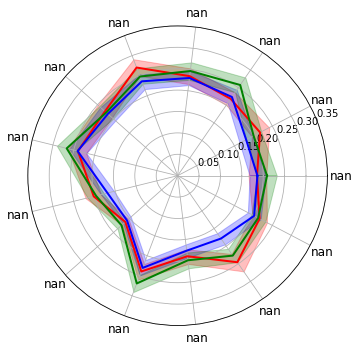

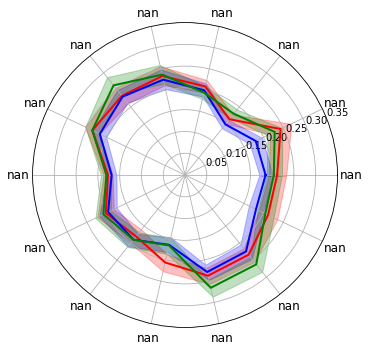

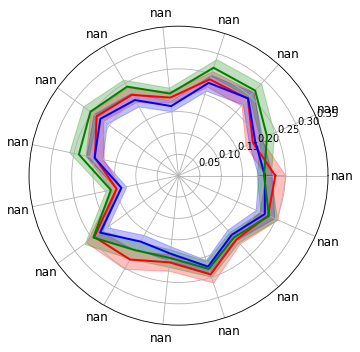

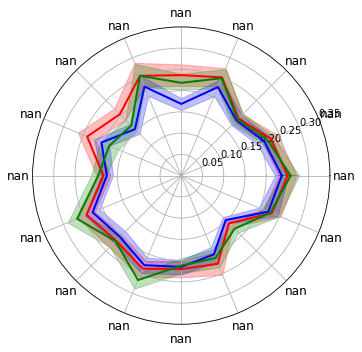

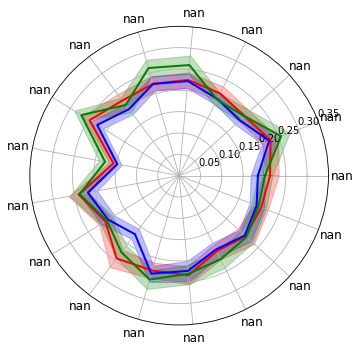

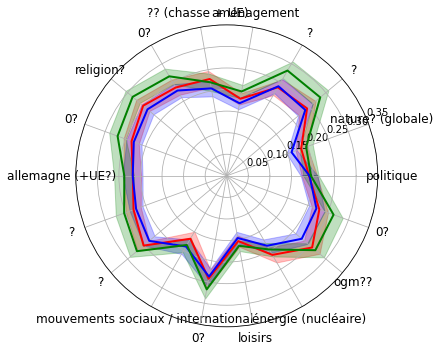

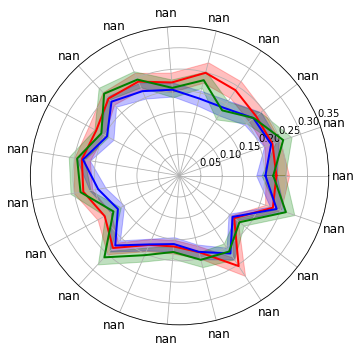

In [176]:
for n_topics in range(3,20):

    TOPICS_NB = n_topics
    N_TOPWORDS = 25
    topics_topwords = topics_df.loc[TOPICS_NB].top_words.values
    topics_topwords = [[w.split('"')[1] for w in topic.split("+")[:N_TOPWORDS]]
                       for topic in topics_topwords
                      ]
    topics_name = topics_df.loc[TOPICS_NB].topic.values

    topics_words_weights = [[float(w.split('*')[0]) for w in topic.split("+")[:N_TOPWORDS]]
                            for topic in topics_df.loc[TOPICS_NB].top_words.values
                           ]
    
    angles=np.linspace(0, 2*np.pi, len(topics_topwords), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(int(str("1"+"3"+"{}".format(i+1))), polar=True)

    for i, model in enumerate(models):

        ecologie_lemma_vectors = [model.wv[w_ecolo] for w_ecolo in ecologie_lemma]
        topics_vec = [[model.wv[w_topic] for w_topic in topic if (w_topic in model.wv.key_to_index.keys())] 
                      for topic in topics_topwords]
        #print(i, [len(topic) for topic in topics_vec])

        stats_mean = [np.mean(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()) 
                      for word_vects in topics_vec] 
        stats_mean = np.concatenate((stats_mean,[stats_mean[0]]))

        #stats_std = [np.std(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten()) 
         #             for word_vects in topics_vec] 
        #stats_std = np.concatenate((stats_std,[stats_std[0]]))
        
        stats_btstrp = [bootstrap_CI(pairwise.cosine_similarity(word_vects, ecologie_lemma_vectors).flatten())
                    for word_vects in topics_vec
                   ]
        stats_btstrp = np.concatenate((stats_btstrp,[stats_btstrp[0]]))
        stats_btstrp_min = [btstrp[0] for btstrp in stats_btstrp]
        stats_btstrp_max = [btstrp[1] for btstrp in stats_btstrp]

        #ax = fig.add_subplot(int(str("1"+"3"+"{}".format(i+1))), polar=True)

        ax.plot(angles
                , stats_mean
                #, 'o-'
                , color=colors[i]
                , linewidth=2
               )
        ax.fill_between(angles
                , y1=stats_btstrp_min#stats_mean-stats_std
                , y2= stats_btstrp_max#stats_mean+stats_std
                , alpha=0.25
                , color=colors[i]
               )

        ax.set_thetagrids(angles[:-1]* 180/np.pi, topics_name, fontsize=12)
        ax.set_rlim(0,0.35)
        #ax.set_title(periods[i]
        #             , fontsize = 18, weight = 'demibold',  x = 0.5, y = 1.1
        #            )
        plt.grid(True)

    plt.tight_layout()
    #plt.savefig("test_spider.png")